In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc

In [2]:
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import os

/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
path2fig = "/home/xinyuelu/AD-proj/results/figures-annotate-hPFC/joint_modality"
path2anno = "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/annotation"
path2res = "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/joint_modality"
os.makedirs(path2fig, exist_ok=True)
os.makedirs(path2res, exist_ok=True)

## Load Hi-C embedding

In [8]:
path2hicembed = f"{path2res}/fh_embedding.h5ad"
adata = sc.read_h5ad(path2hicembed)
adata

AnnData object with n_obs × n_vars = 48306 × 256

## Load RNA embedding

In [23]:
path2rnaembed = f"{path2anno}/preprocess/PCA_RNA-Seurat_hPFC-lib-all.csv"
path2rnalabel = f"{path2anno}/meta-Seurat-all_hPFC-lib-all.csv"

In [24]:
rnaembed = pd.read_csv(path2rnaembed, index_col = 0)
rnaembed.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
"hPFC-lib-1_A1,A7",-12.797497,21.802468,-8.649428,-13.053099,-1.908512,-4.559227,-0.382792,-0.093093,0.373303,-0.992181,...,1.121265,0.512310,-1.192414,-0.169228,-1.017151,-1.545022,1.273023,-0.046826,0.280354,0.979948
"hPFC-lib-1_A1,C5",-3.634392,0.330334,5.379678,0.590821,-3.120164,1.809079,9.484127,-0.176752,0.428102,0.290696,...,0.453289,-0.467759,-1.670674,-0.837061,1.389145,-0.103086,-0.990220,-0.923444,-2.216092,0.736831
"hPFC-lib-1_A1,C8",-3.464313,3.737335,2.218404,5.992520,0.796100,-0.111323,0.171308,-0.742251,-0.003568,0.626356,...,1.159033,-0.657313,1.322594,-0.225798,0.241238,-0.056737,0.466319,-0.910064,-0.425509,-0.120572
"hPFC-lib-1_A1,C12",1.205734,-1.666489,8.694931,-3.781727,-0.564076,-1.291606,-0.998956,1.475359,-1.401118,-3.874711,...,0.096514,0.622100,-0.889041,-0.157495,0.085364,-2.224718,-2.417630,-2.162058,-0.648075,-0.643727
"hPFC-lib-1_A1,D2",-3.432756,3.191738,2.425752,7.319379,-0.220909,-0.431488,0.686802,-1.019116,0.663678,-0.200929,...,-1.072681,-0.004636,-0.584318,0.885781,0.352550,-0.407479,-0.220955,-0.573697,-0.041760,0.228011


In [25]:
rnalabel = pd.read_csv(path2rnalabel)
rnalabel = rnalabel.rename(columns={"Unnamed: 0":"index"})
rnalabel = rnalabel.set_index("index")
rnalabel.head()

,raw.ident,major_cell_type,sub_cell_type,condition,sex,sample_id,DNA.long.short
index,,,,,,,
"hPFC-lib-1_A1,A7",19,Micro,Micro,CT,Female,21272396,0.246465
"hPFC-lib-1_A1,C5",18,OPC,OPC,AD,Male,66754397,0.239154
"hPFC-lib-1_A1,C8",7,Oligo,Oligo,AD,Male,66754397,0.244462
"hPFC-lib-1_A1,C12",15,Inh,Inh Sst,AD,Male,66754397,0.172353
"hPFC-lib-1_A1,D2",0,Oligo,Oligo,AD,Male,66754397,0.302903


In [26]:
rnaembed.shape, rnalabel.shape

((27365, 50), (26889, 7))

## Intersection with Hi-C cells

In [27]:
common_cells = set(rnalabel.index) & set(adata.obs_names)
print(f"Length of common cells: {len(common_cells)}")

Length of common cells: 26373


In [28]:
rnaembed = rnaembed.loc[list(common_cells)]
rnalabel = rnalabel.loc[list(common_cells)]

In [29]:
rnalabel = rnalabel.loc[list(common_cells)]
rnalabel.shape

(26373, 7)

In [30]:
fadata = adata[adata.obs_names.isin(common_cells), :]
fadata = fadata[list(common_cells), :]

In [31]:
all(fadata.obs_names == rnalabel.index)

True

In [32]:
fadata.obs = fadata.obs.merge(rnalabel, left_index=True, right_index=True, how="left")

In [33]:
fadata.obs.head()

,raw.ident,major_cell_type,sub_cell_type,condition,sex,sample_id,DNA.long.short
"hPFC-lib-44_B6,D7",34,Exc,Exc L5/6 NP,AD,Female,84417209,0.195205
"hPFC-lib-43_H5,C1",17,Exc,Exc L5 IT,AD,Female,20780035,0.153510
"hPFC-lib-4_D7,D1",2,Exc,Exc L2/3 IT,AD,Male,66754397,0.172855
"hPFC-lib-28_F10,C2",4,Exc,Exc L4 IT,AD,Female,20780035,0.179579
"hPFC-lib-23_B7,D10",24,Endo,Endo,CT,Male,10291856,0.247352


## Initial Hi-C embedding

In [34]:
vec = UMAP(n_components=2, n_neighbors=20, min_dist=0.3).fit_transform(fadata.X)

In [36]:
cell_type_colors = {
    "Exc L2/3 IT": "#b1ed30",
    "Exc L4 IT": "#00e5e5",
    "Exc L5 IT": "#51b3ac",
    "Exc L5 ET": "#0e5c79",
    "Exc L5/6 NP": "#3d9e64",
    "Exc L6b": "#7045aa",
    "Exc L6 CT": "#2d8db8",
    "Exc L6 IT": "#a29922",
    "Exc L6 IT Car3": "#5105ff",
    "Inh Lamp5": "#db808c",
    "Inh Sst": "#ff9902",
    "Inh Sncg": "#e070ff",
    "Inh Pvalb": "#d93138",
    "Inh Vip": "#a45fc0",
    "Inh PAX6": "#73248d",
    "Inh Chandelier": "#f642a8",
    "Oligo": "#53776d",
    "Astro": "#665d47",
    "Micro": "#94af97",
    "OPC": "#374b45",
    "Endo": "#8d6d64",
    "VLMC": "#697256"
}

cell_types = list(cell_type_colors.keys())
colors = [cell_type_colors[ct] for ct in cell_types]

In [37]:
vec = UMAP(n_components=2, n_neighbors=20, min_dist=0.3, random_state=0).fit_transform(fadata.X)

/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


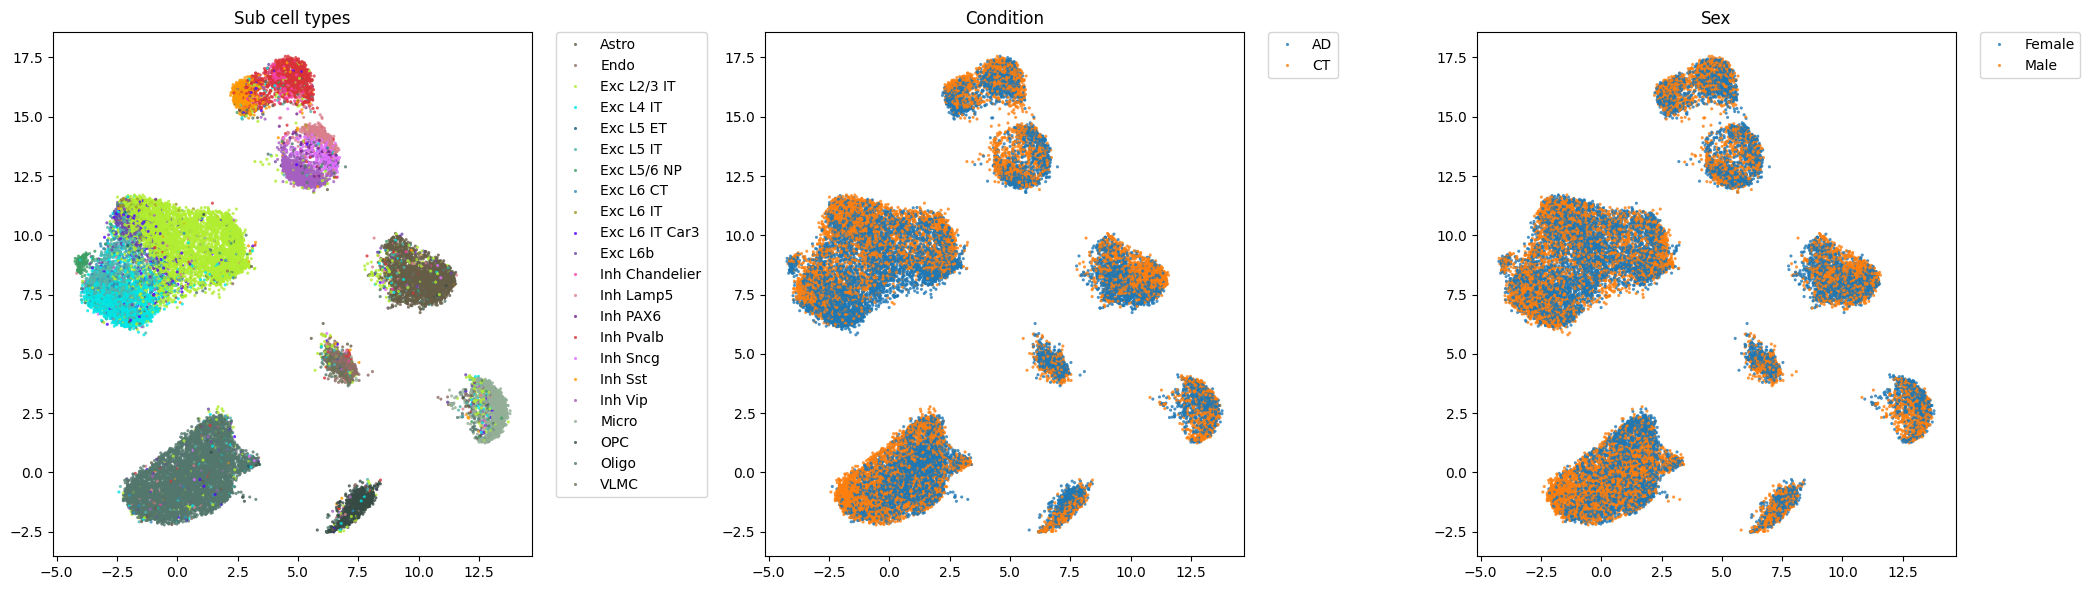

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6)) 

hues = [rnalabel['sub_cell_type'], rnalabel['condition'], rnalabel['sex']]
hue_titles = ['Sub cell types', 'Condition', 'Sex']  

for i, ax in enumerate(axes):
    if i == 0:
        sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0, palette=colors, hue_order=cell_types 
        )
    else:
        sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0
        )
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
    
    ax.set_title(hue_titles[i])

plt.tight_layout() 
for suffix in ['png', 'pdf']:
    path2file = f"{path2res}/fast-higashi-embed-unfiltered.{suffix}"
    plt.savefig(path2file, dpi=500, bbox_inches="tight")


## Filter cells

/home/xinyuelu/AD-proj/results/results-annotate-hPFC/joint_modality/cluster-refinement-confusionmatrix.png
/home/xinyuelu/AD-proj/results/results-annotate-hPFC/joint_modality/cluster-refinement-confusionmatrix.pdf


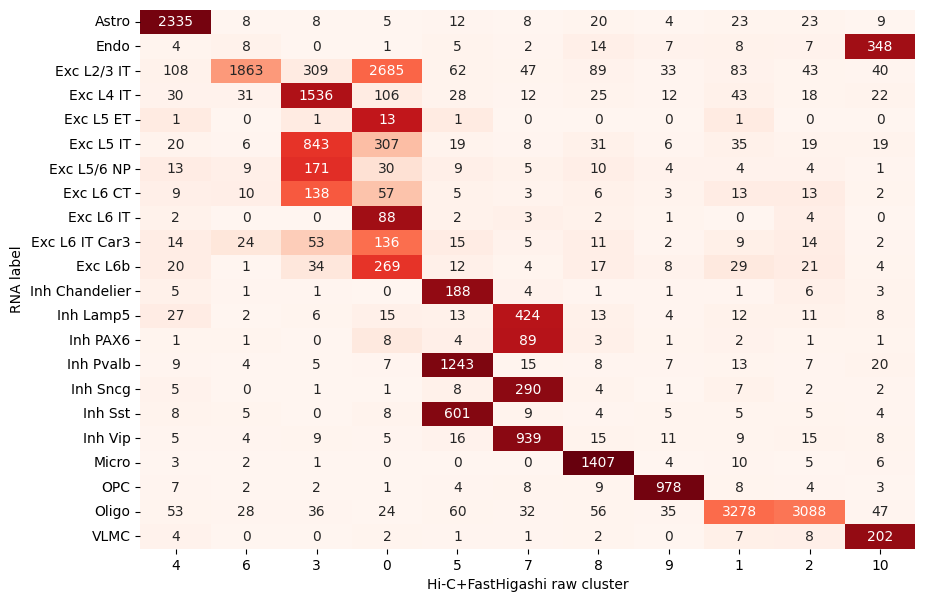

In [41]:
def f(adata, ax, mask, n_neighbors, resolution):
    adata.obsm['X_pca'] = adata.X
    adata = adata[mask].copy()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=adata.obsm['X_pca'].shape[1])
    sc.tl.louvain(adata, resolution=resolution)
    df = pd.DataFrame([
            adata.obs['sub_cell_type'].rename('RNA label'),
            adata.obs['louvain'].rename('Hi-C+FastHigashi raw cluster')]).T
    df = df.groupby(list(df.columns)).size().unstack().fillna(0).astype(int)
    df = df.iloc[:, np.argsort(np.argmax(df.div(df.sum(1), 0).values, 0))]
    df.head()
    sns.heatmap(df.div(df.sum(1), 0), annot=df, ax=ax, cmap='Reds', fmt='d', cbar=False)
    return df, adata.obs

fig, axes = plt.subplots(1, 1, figsize=(10, 7))  
df, df_meta_final = f(fadata, axes, slice(None), 20, 1)
for suffix in ['png', 'pdf']:
    path2file = f'{path2res}/cluster-refinement-confusionmatrix.{suffix}'
    print(path2file)
    plt.savefig(path2file, dpi=600)
plt.show()
plt.close('all')

In [45]:
df_div = df.div(df.sum(1), 0)

In [48]:
remain_cell_type_dict = {
    row: df_div.columns[(df_div.loc[row] > 0.2) | (df.loc[row] > 300)].tolist()
    for row in df_div.index
}

In [50]:
remain_cell_type_dict

{'Astro': ['4'],
 'Endo': ['10'],
 'Exc L2/3 IT': ['6', '3', '0'],
 'Exc L4 IT': ['3'],
 'Exc L5 ET': ['0'],
 'Exc L5 IT': ['3', '0'],
 'Exc L5/6 NP': ['3'],
 'Exc L6 CT': ['3', '0'],
 'Exc L6 IT': ['0'],
 'Exc L6 IT Car3': ['0'],
 'Exc L6b': ['0'],
 'Inh Chandelier': ['5'],
 'Inh Lamp5': ['7'],
 'Inh PAX6': ['7'],
 'Inh Pvalb': ['5'],
 'Inh Sncg': ['7'],
 'Inh Sst': ['5'],
 'Inh Vip': ['7'],
 'Micro': ['8'],
 'OPC': ['9'],
 'Oligo': ['1', '2'],
 'VLMC': ['10']}

In [51]:
for cell_type, keep_clusters in remain_cell_type_dict.items():
    keep_clusters = [str(item) for item in keep_clusters]
    condition = (~df_meta_final['louvain'].isin(keep_clusters)) & (df_meta_final['sub_cell_type'] == cell_type)
    df_meta_final = df_meta_final[~condition] 

In [52]:
df_meta_final.shape

(23825, 8)

## Embedding after filtering

In [53]:
mask_cells = df_meta_final.index
fadata = adata[adata.obs_names.isin(mask_cells), :]
fadata = fadata[list(mask_cells), :]

In [54]:
rnaembed = rnaembed.loc[list(mask_cells)]
print(rnaembed.shape)
rnalabel = rnalabel.loc[list(mask_cells)]
print(rnalabel.shape)

(23825, 50)
(23825, 7)


In [55]:
vec1 = UMAP(n_components=2, n_neighbors=20, min_dist=0.3, random_state=0).fit_transform(fadata.X)
vec2 = UMAP(n_components=2, n_neighbors=20, min_dist=0.3, random_state=0).fit_transform(rnaembed.values[:,0:45])

/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/envs/3Dgenome/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [56]:
df = pd.DataFrame(vec1)
df.index = rnalabel.index
df.to_csv(f"{path2res}/HiC_final_embedding.csv")

In [57]:
df = pd.DataFrame(vec2)
df.index = rnalabel.index
df.to_csv(f"{path2res}/RNA_final_embedding.csv")

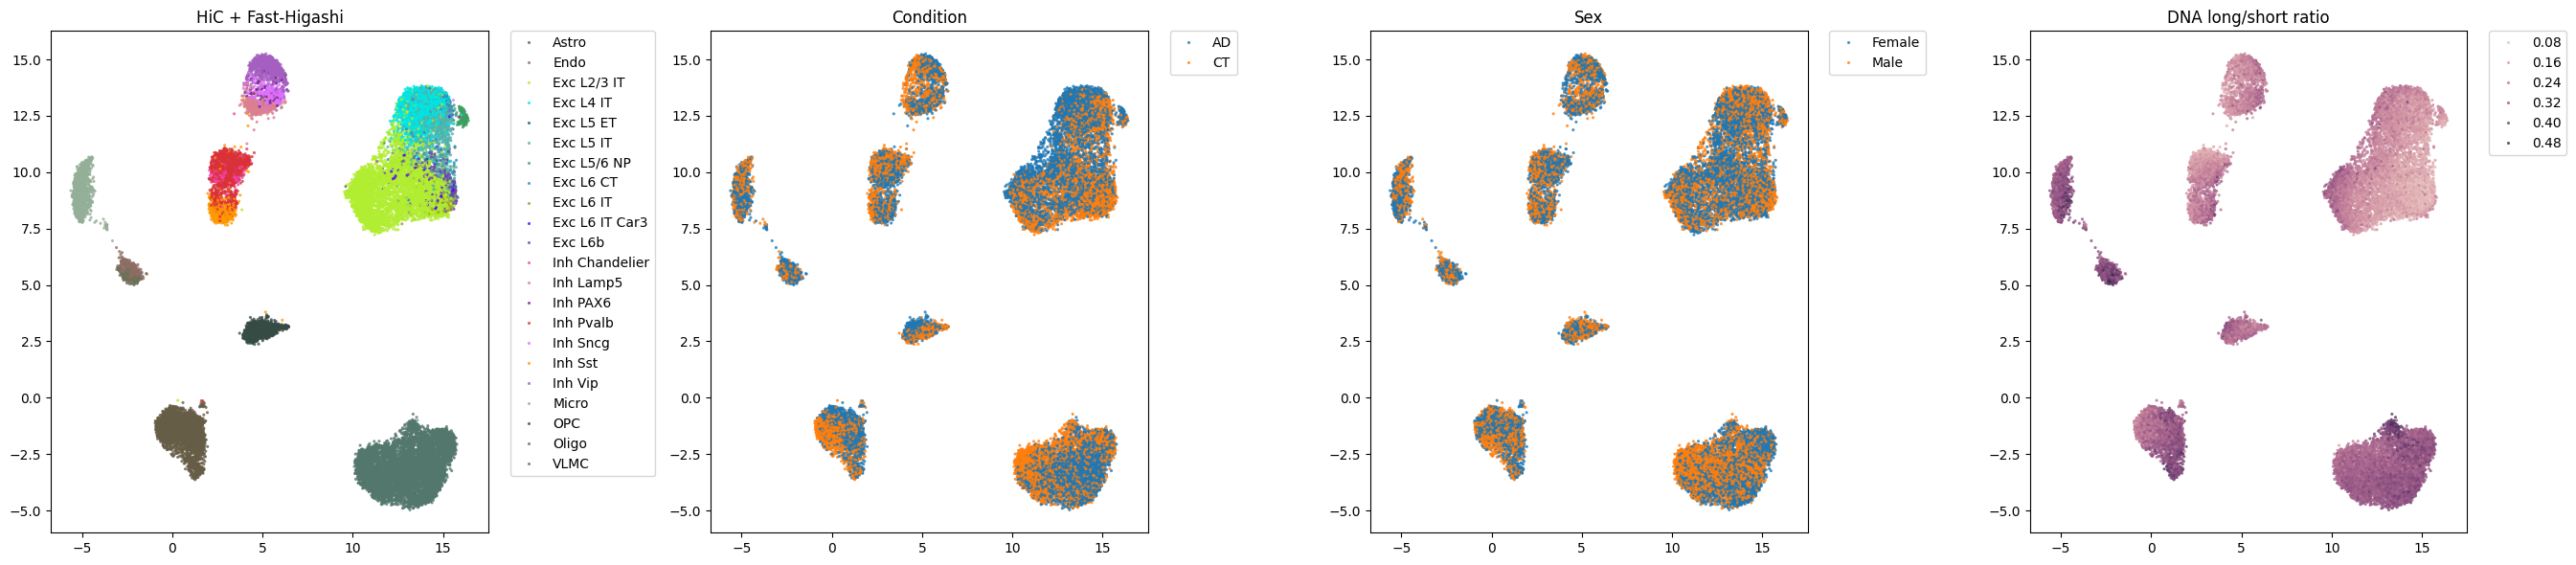

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(27, 6)) 

hues = [rnalabel['sub_cell_type'], rnalabel['condition'], rnalabel['sex'], rnalabel['DNA.long.short']]
hue_titles = ['HiC + Fast-Higashi', 'Condition', 'Sex', 'DNA long/short ratio']  


for i, ax in enumerate(axes):
    if i == 0:
        sns.scatterplot(x=vec1[:, 0], y=vec1[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0, palette=colors, hue_order=cell_types 
        )
    else:
        sns.scatterplot(x=vec1[:, 0], y=vec1[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0
        )
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
    
    ax.set_title(hue_titles[i])

plt.tight_layout() 
for suffix in ['png', 'pdf']:
    plt.savefig(f"{path2res}/HiC-fast-higashi-filtered.{suffix}", dpi=500, bbox_inches="tight")

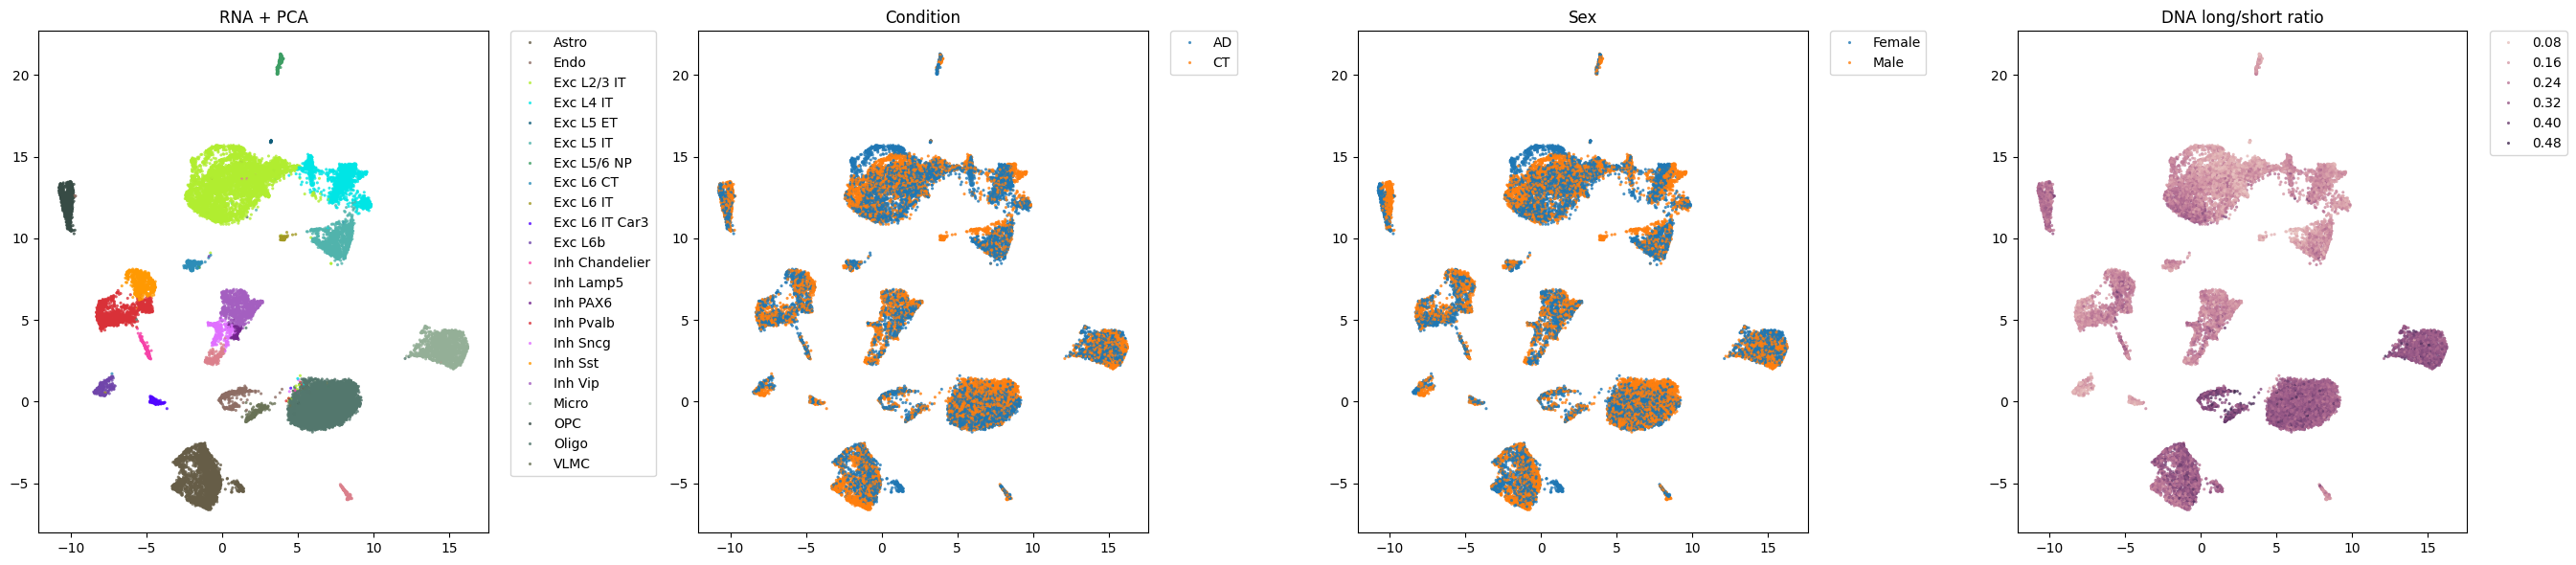

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(27, 6)) 

hues = [rnalabel['sub_cell_type'], rnalabel['condition'], rnalabel['sex'], rnalabel['DNA.long.short']]
hue_titles = ['RNA + PCA', 'Condition', 'Sex', 'DNA long/short ratio']  

for i, ax in enumerate(axes):
    if i == 0:
        sns.scatterplot(x=vec2[:, 0], y=vec2[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0, palette=colors, hue_order=cell_types 
        )
    else:
        sns.scatterplot(x=vec2[:, 0], y=vec2[:, 1], hue=hues[i], ax=ax, s=5,
            alpha=0.8, linewidth=0
        )
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
    
    ax.set_title(hue_titles[i])

plt.tight_layout() 
for suffix in ['png', 'pdf']:
    plt.savefig(f"{path2res}/RNA-PCA-filtered.{suffix}", dpi=500, bbox_inches="tight")

In [61]:
rnalabel.to_csv(f"{path2res}/valid_cell_meta_filtered.csv")

## Basic stats

In [74]:
path2res = "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/stats"

In [66]:
sample_ids = [
    65652206, 10383017, 10291856, 77239958, 37178462,
    78353027, 66754397, 78452313, 12365619, 50410319,
    57978756, 86934089, 21272396, 23690880, 37030589,
    85171938, 50403446, 84417209, 20780035, 76733461
]

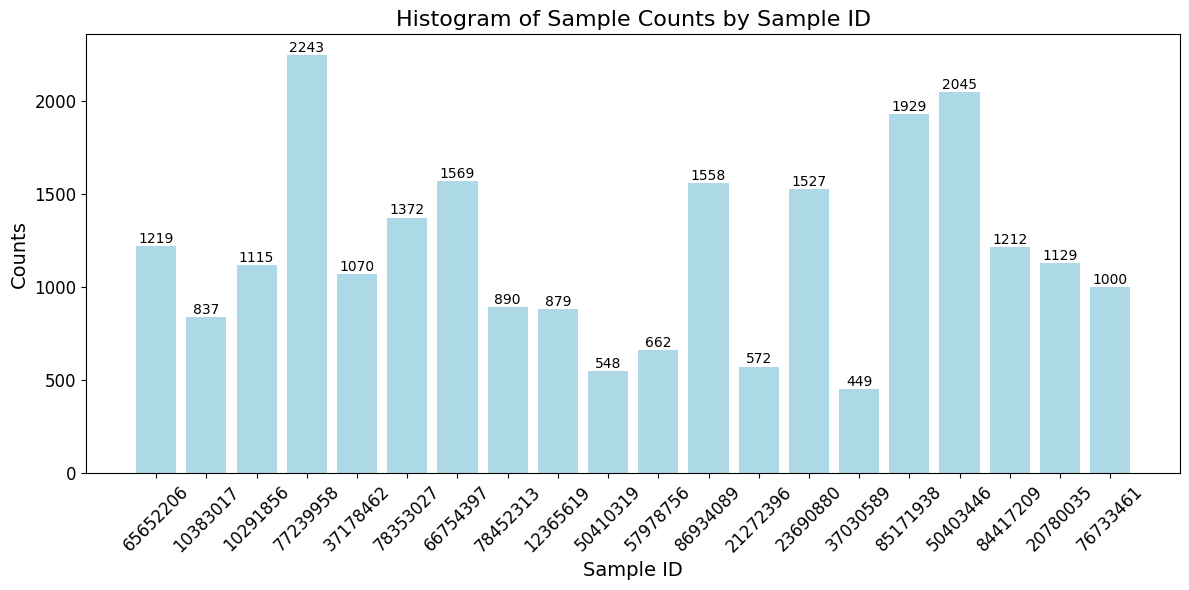

In [76]:
counts = rnalabel["sample_id"].value_counts().reset_index()
counts.columns = ["sample_id", "count"]

sorted_counts = counts.set_index("sample_id").reindex(sample_ids).reset_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_counts["sample_id"].astype(str), sorted_counts["count"], color='lightblue')

for bar, count in zip(bars, sorted_counts["count"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        bar.get_height() + 0.5, 
        f"{int(count)}",  
        ha="center", va="bottom", fontsize=10  
    )
plt.title("Histogram of Sample Counts by Sample ID", fontsize=16)
plt.xlabel("Sample ID", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

for suffix in ['png', 'pdf']:
    plt.savefig(f"{path2res}/per-sample-counts-filtered.{suffix}", dpi=500, bbox_inches="tight")


/var/tmp/ipykernel_1249672/290188176.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


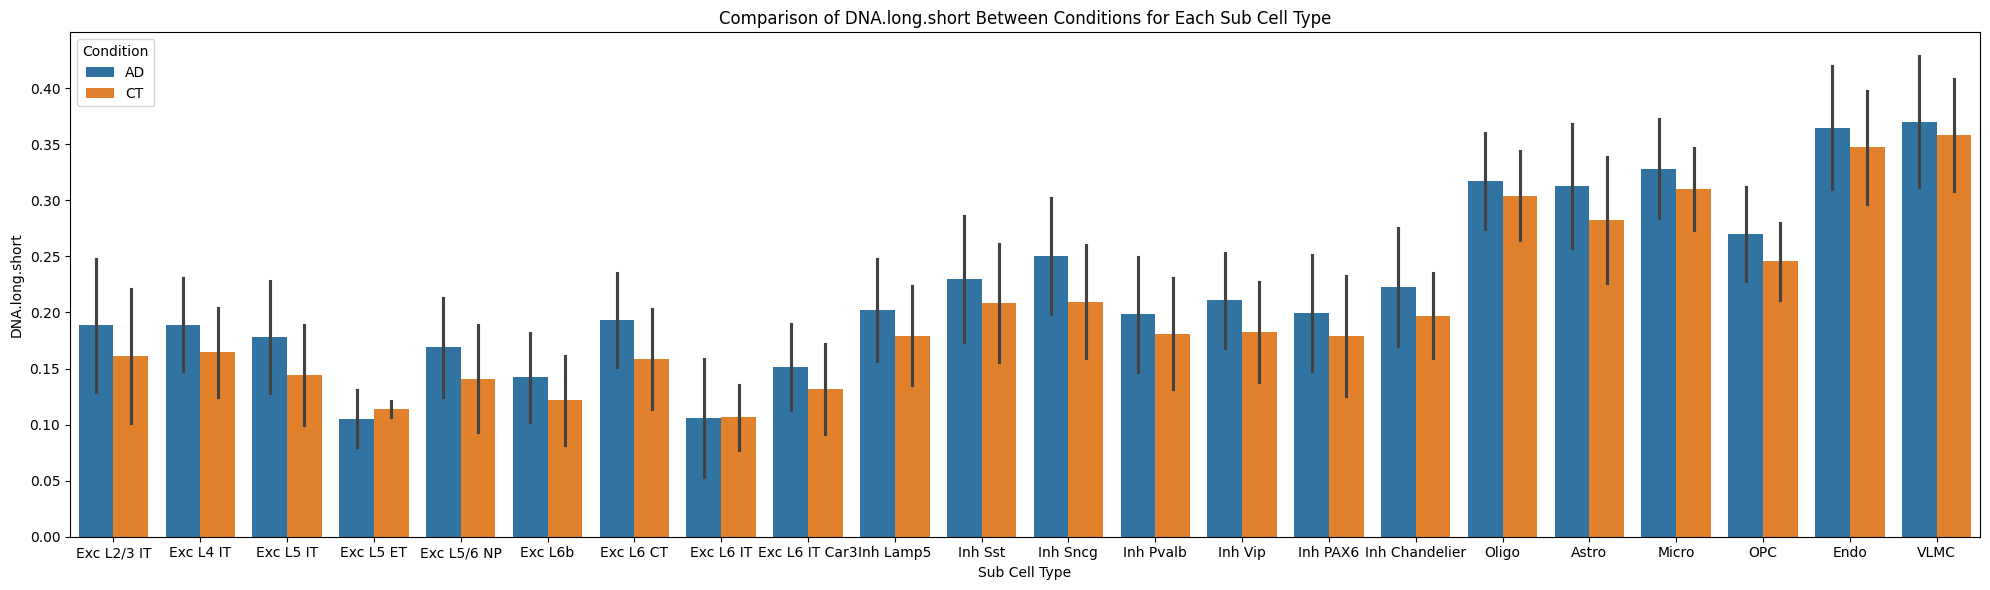

In [77]:
plt.figure(figsize=(20, 6))

sns.barplot(
    data=rnalabel,
    x="sub_cell_type",
    y="DNA.long.short",
    hue="condition",
    order=cell_types,
    ci="sd"
)

plt.title("Comparison of DNA.long.short Between Conditions for Each Sub Cell Type")
plt.xlabel("Sub Cell Type")
plt.ylabel("DNA.long.short")
plt.legend(title="Condition")
plt.tight_layout()

for suffix in ['png', 'pdf']:
    plt.savefig(f"{path2res}/DNA-long-short-ratio.{suffix}", dpi=500, bbox_inches="tight")